In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from google.colab import files
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()


In [ ]:
from torch.cuda import device_of
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# determine the device to be used for training and evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


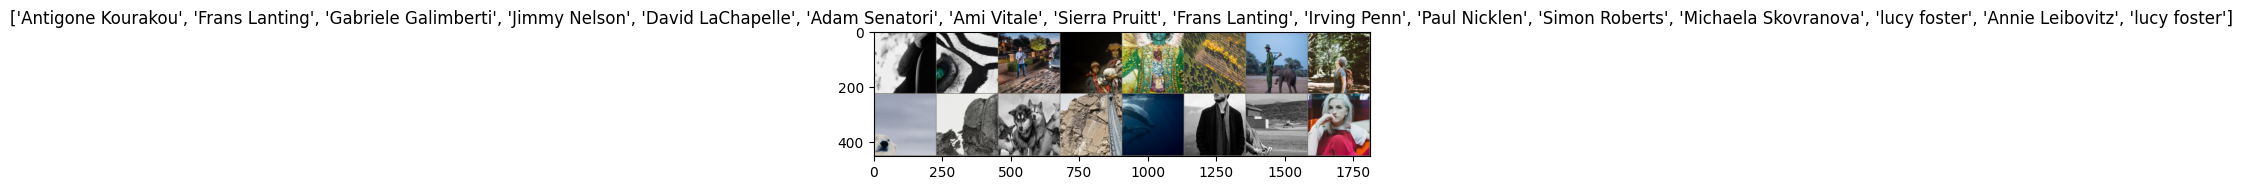

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [ ]:
import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    #best_model_wts = copy.deepcopy(model_.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]



            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
model = models.vgg16(pretrained=True)

# Replace final layer with new layer for the new task
num_classes = 48
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)

# Move model to device
model_ft = model.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.8MB/s]


In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


 97%|█████████▋| 198/205 [06:33<00:08,  1.23s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [06:49<00:00,  2.00s/it]


train Loss: 3.1048 Acc: 0.2147


100%|██████████| 51/51 [01:51<00:00,  2.19s/it]


test Loss: 2.8177 Acc: 0.2691

Epoch 1/9
----------


 85%|████████▍ | 174/205 [01:28<00:14,  2.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.99it/s]


train Loss: 2.4213 Acc: 0.3507


100%|██████████| 51/51 [00:23<00:00,  2.18it/s]


test Loss: 2.6734 Acc: 0.3160

Epoch 2/9
----------


 60%|██████    | 123/205 [01:04<00:46,  1.78it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.97it/s]


train Loss: 2.0434 Acc: 0.4325


100%|██████████| 51/51 [00:25<00:00,  2.00it/s]


test Loss: 2.5325 Acc: 0.3272

Epoch 3/9
----------


 85%|████████▍ | 174/205 [01:29<00:12,  2.40it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:42<00:00,  1.99it/s]


train Loss: 1.9245 Acc: 0.4628


100%|██████████| 51/51 [00:23<00:00,  2.18it/s]


test Loss: 2.5772 Acc: 0.3321

Epoch 4/9
----------


 95%|█████████▍| 194/205 [01:39<00:03,  3.09it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.97it/s]


train Loss: 1.7951 Acc: 0.4904


100%|██████████| 51/51 [00:25<00:00,  1.98it/s]


test Loss: 2.4650 Acc: 0.3778

Epoch 5/9
----------


 80%|████████  | 165/205 [01:25<00:22,  1.79it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.98it/s]


train Loss: 1.8424 Acc: 0.4919


100%|██████████| 51/51 [00:23<00:00,  2.16it/s]


test Loss: 2.5131 Acc: 0.3617

Epoch 6/9
----------


 30%|██▉       | 61/205 [00:34<01:19,  1.81it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.98it/s]


train Loss: 1.4994 Acc: 0.5715


100%|██████████| 51/51 [00:25<00:00,  1.96it/s]


test Loss: 2.6779 Acc: 0.3358

Epoch 7/9
----------


  8%|▊         | 17/205 [00:10<02:37,  1.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.98it/s]


train Loss: 1.1623 Acc: 0.6616


100%|██████████| 51/51 [00:23<00:00,  2.16it/s]


test Loss: 2.3762 Acc: 0.4284

Epoch 8/9
----------


 93%|█████████▎| 190/205 [01:37<00:06,  2.29it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.98it/s]


train Loss: 1.0684 Acc: 0.6873


100%|██████████| 51/51 [00:25<00:00,  1.99it/s]


test Loss: 2.3712 Acc: 0.4210

Epoch 9/9
----------


 38%|███▊      | 78/205 [00:41<01:47,  1.18it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:43<00:00,  1.97it/s]


train Loss: 1.0235 Acc: 0.6989


100%|██████████| 51/51 [00:23<00:00,  2.14it/s]

test Loss: 2.3828 Acc: 0.4210

Training complete in 27m 54s
Best test Acc: 0.428395


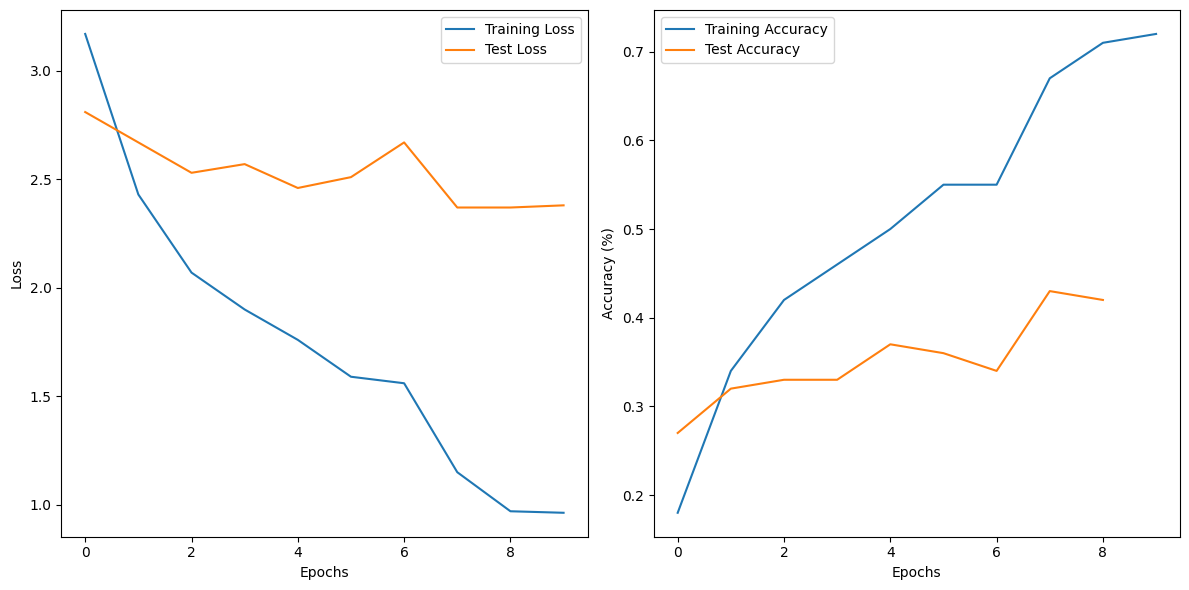

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.17,2.43,2.07,1.90,1.76,1.59,1.56,1.15,0.97,0.963]
test_losses = [2.81,2.67,2.53,2.57,2.46,2.51,2.67,2.37,2.37,2.38]
training_accuracies = [0.18,0.34,0.42,0.46,0.50,0.55,0.55,0.67,0.71,0.72]
test_accuracies = [0.27,0.32,0.33,0.33,0.37,0.36,0.34,0.43,0.42,]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


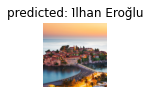

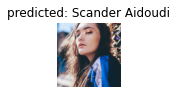

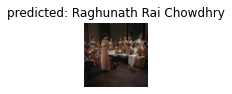

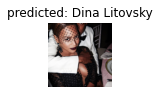

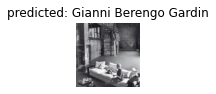

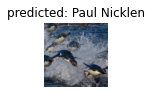

In [ ]:
visualize_model(model_ft)

In [ ]:
!pip install scikit-learn

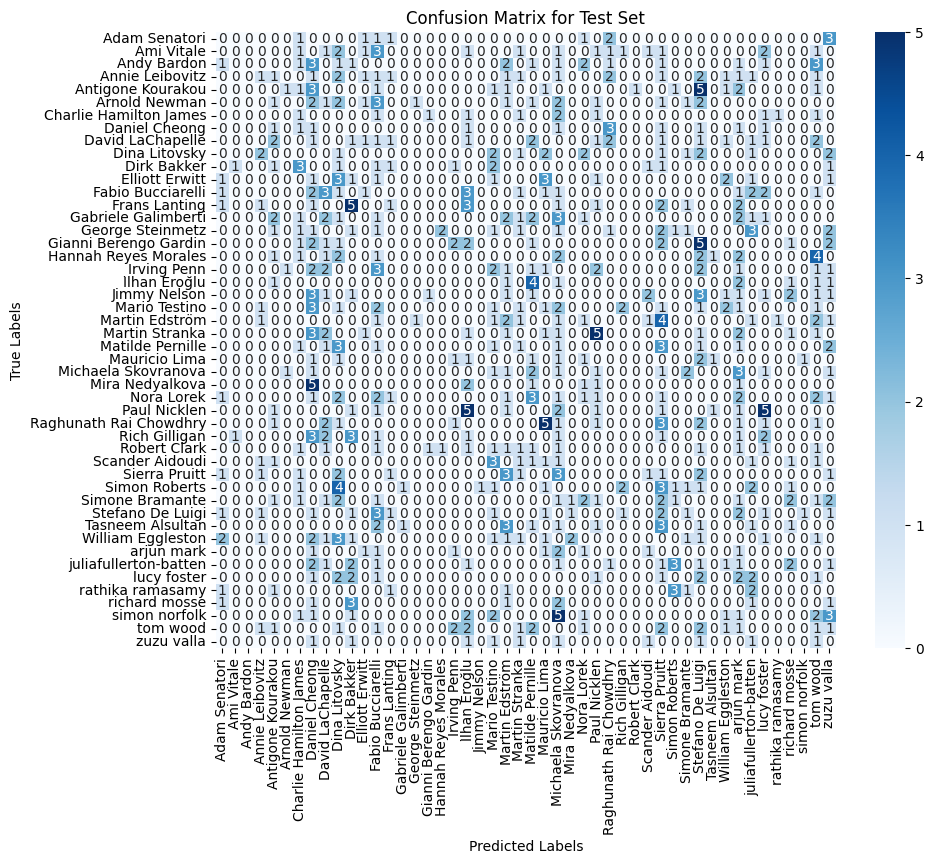

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy

def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Save confusion matrix to a file
    np.savetxt("confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(model_ft)

In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics.csv")

# Print first 10 rows to check
print(results.head(48))


Confusion matrix shape: (48, 48)
                         TP    FP    FN     TN  Precision    Recall  F1-Score
Class                                                                        
Adam Senatori           0.0  11.0  10.0  789.0   0.000000  0.000000  0.000000
Ami Vitale              0.0   2.0  19.0  789.0   0.000000  0.000000  0.000000
Andy Bardon             0.0   0.0  20.0  790.0   0.000000  0.000000  0.000000
Annie Leibovitz         1.0  10.0  19.0  780.0   0.090909  0.050000  0.064516
Antigone Kourakou       0.0  17.0  20.0  773.0   0.000000  0.000000  0.000000
Arnold Newman           0.0   3.0  20.0  787.0   0.000000  0.000000  0.000000
Charlie Hamilton James  1.0  18.0  10.0  781.0   0.052632  0.090909  0.066667
Daniel Cheong           1.0  49.0  11.0  749.0   0.020000  0.083333  0.032258
David LaChapelle        0.0  23.0  20.0  767.0   0.000000  0.000000  0.000000
Dina Litovsky           1.0  38.0  16.0  755.0   0.025641  0.058824  0.035714
Dirk Bakker             0.0  25

<Figure size 2200x1000 with 0 Axes>

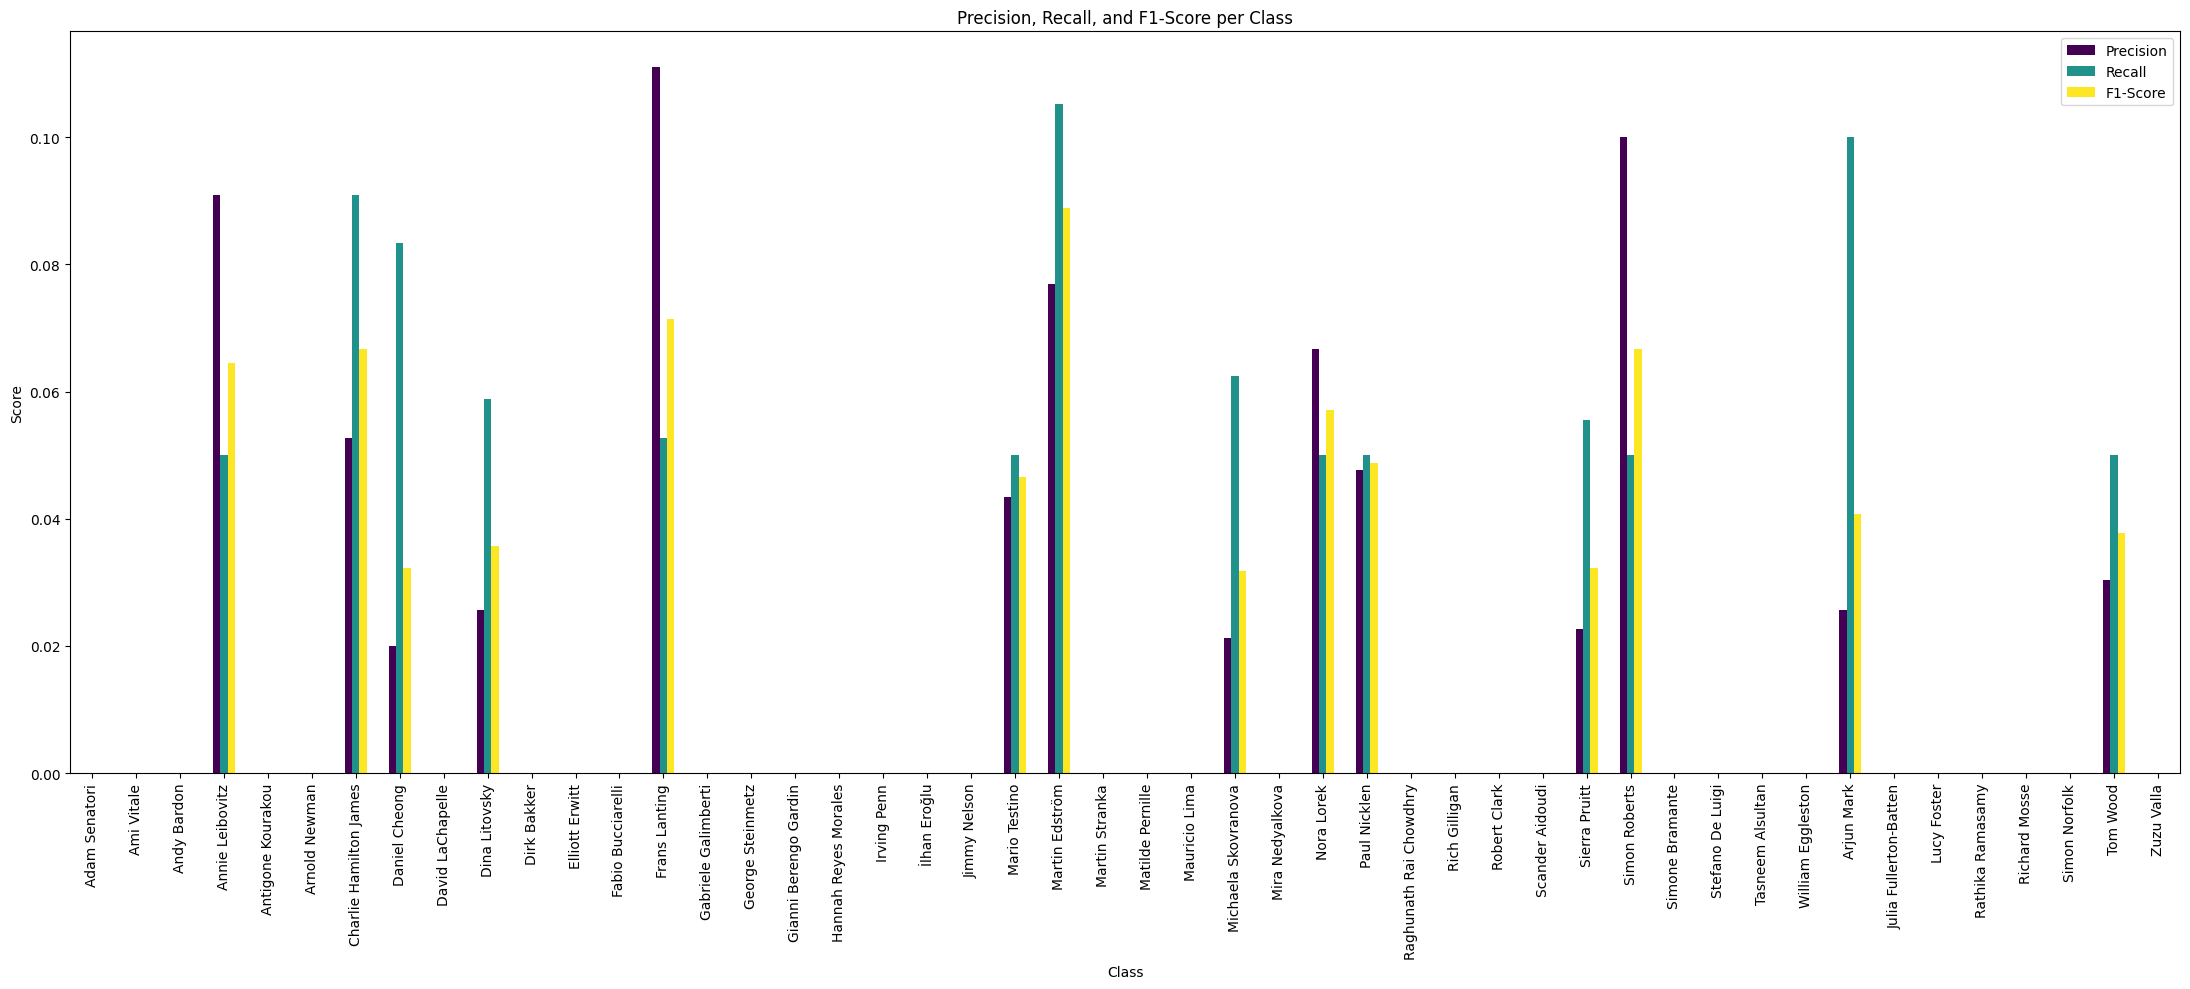

In [ ]:
plt.figure(figsize=(22, 10))
metrics = ['Precision', 'Recall', 'F1-Score']
results_plot = results[metrics]

results_plot.plot(kind='bar', figsize=(22, 10), colormap='viridis')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
model_conv = models.vgg16(pretrained=True)

# Freeze all original parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Replace final layer with new layer for the new task
num_classes = 48
in_features = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = nn.Linear(in_features, num_classes)

# Move model to device
model_conv = model_conv.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


  9%|▉         | 19/205 [00:12<01:21,  2.28it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:57<00:00,  1.75it/s]


train Loss: 3.1642 Acc: 0.2040


100%|██████████| 51/51 [00:29<00:00,  1.73it/s]


test Loss: 2.8497 Acc: 0.2580

Epoch 1/9
----------


 64%|██████▍   | 132/205 [01:16<00:30,  2.39it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:55<00:00,  1.77it/s]


train Loss: 2.4385 Acc: 0.3611


100%|██████████| 51/51 [00:29<00:00,  1.72it/s]


test Loss: 2.6986 Acc: 0.2963

Epoch 2/9
----------


 90%|████████▉ | 184/205 [01:46<00:08,  2.59it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:56<00:00,  1.76it/s]


train Loss: 2.1820 Acc: 0.4012


100%|██████████| 51/51 [00:29<00:00,  1.72it/s]


test Loss: 2.6589 Acc: 0.3062

Epoch 3/9
----------


 61%|██████▏   | 126/205 [01:12<00:39,  1.98it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:56<00:00,  1.77it/s]


train Loss: 2.0485 Acc: 0.4377


100%|██████████| 51/51 [00:29<00:00,  1.73it/s]


test Loss: 2.6293 Acc: 0.3185

Epoch 4/9
----------


 12%|█▏        | 25/205 [00:15<01:46,  1.70it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:56<00:00,  1.77it/s]


train Loss: 1.9662 Acc: 0.4579


100%|██████████| 51/51 [00:29<00:00,  1.72it/s]


test Loss: 2.6084 Acc: 0.3123

Epoch 5/9
----------


 35%|███▌      | 72/205 [00:42<00:43,  3.04it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:56<00:00,  1.77it/s]


train Loss: 1.8744 Acc: 0.4806


100%|██████████| 51/51 [00:29<00:00,  1.73it/s]


test Loss: 2.6350 Acc: 0.3099

Epoch 6/9
----------


 55%|█████▌    | 113/205 [01:06<00:29,  3.12it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:55<00:00,  1.77it/s]


train Loss: 1.8174 Acc: 0.4937


100%|██████████| 51/51 [00:29<00:00,  1.74it/s]


test Loss: 2.6242 Acc: 0.3222

Epoch 7/9
----------


 53%|█████▎    | 108/205 [01:03<00:48,  1.98it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:54<00:00,  1.79it/s]


train Loss: 1.6903 Acc: 0.5292


100%|██████████| 51/51 [00:29<00:00,  1.74it/s]


test Loss: 2.5688 Acc: 0.3395

Epoch 8/9
----------


 19%|█▉        | 39/205 [00:23<01:20,  2.06it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:54<00:00,  1.78it/s]


train Loss: 1.6885 Acc: 0.5201


100%|██████████| 51/51 [00:29<00:00,  1.74it/s]


test Loss: 2.5551 Acc: 0.3284

Epoch 9/9
----------


 93%|█████████▎| 190/205 [01:48<00:07,  1.96it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [01:54<00:00,  1.78it/s]


train Loss: 1.6566 Acc: 0.5280


100%|██████████| 51/51 [00:29<00:00,  1.74it/s]

test Loss: 2.5542 Acc: 0.3333

Training complete in 24m 12s
Best test Acc: 0.339506


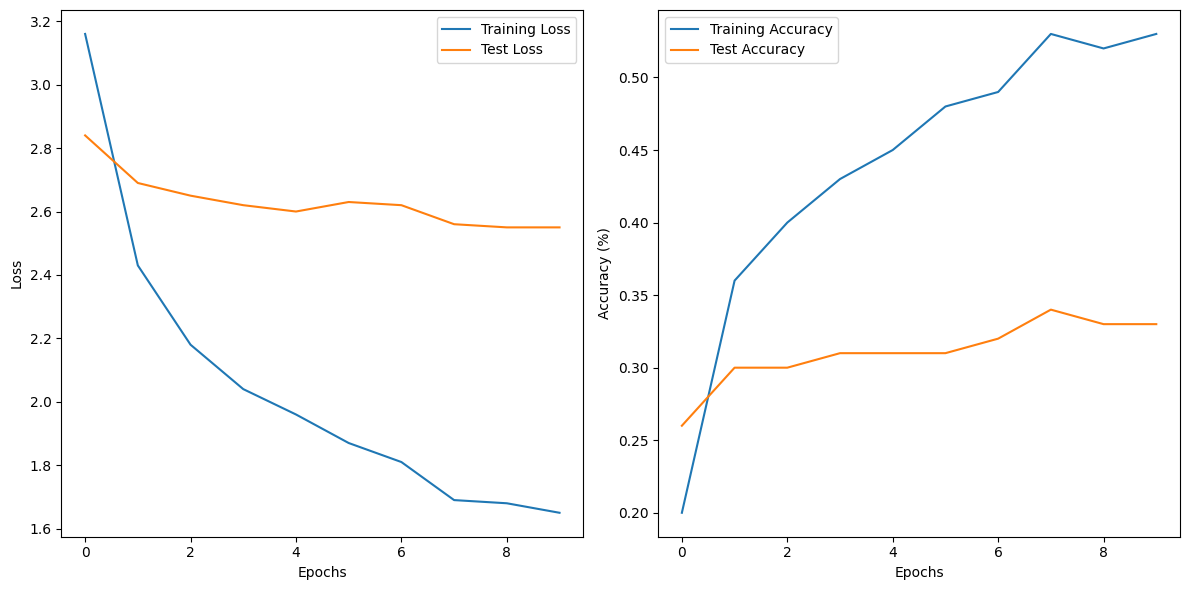

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.16,2.43,2.18,2.04,1.96,1.87,1.81,1.69,1.68,1.65]
test_losses = [2.84,2.69,2.65,2.62,2.60,2.63,2.62,2.56,2.55,2.55]
training_accuracies = [0.20,0.36,0.40,0.43,0.45,0.48,0.49,0.53,0.52,0.53]
test_accuracies = [0.26,0.30,0.30,0.31,0.31,0.31,0.32,0.34,0.33,0.33]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


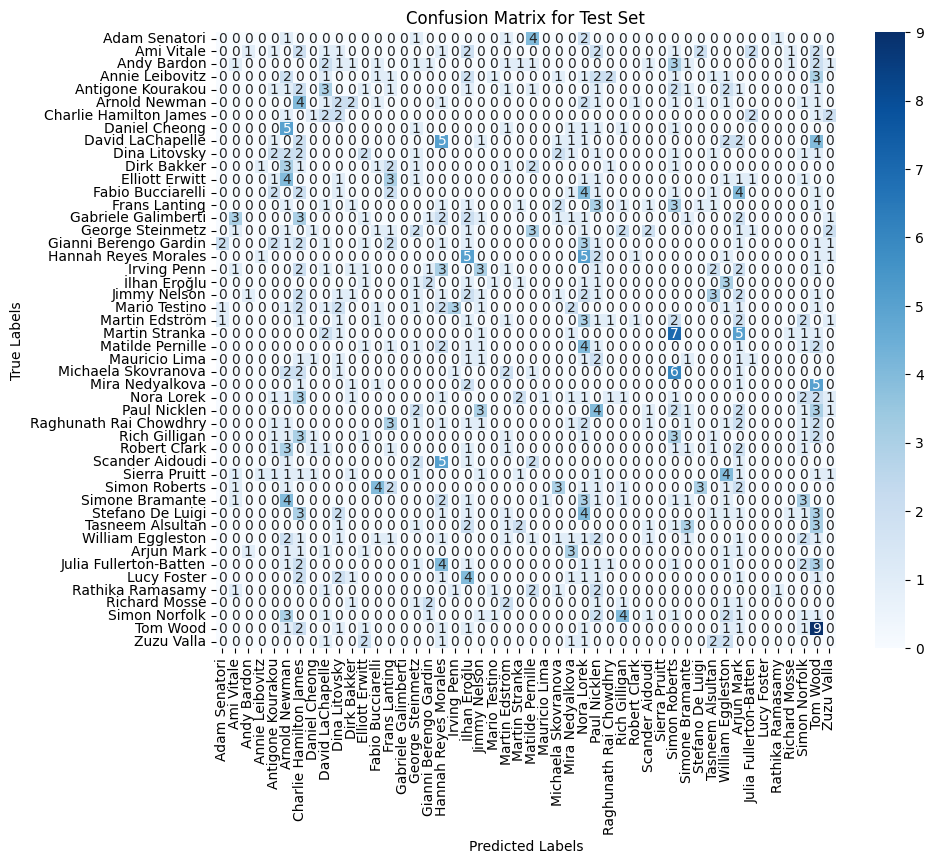

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    np.savetxt("confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(model_conv)

In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics.csv")

# Print first 10 rows to check
print(results.head(48))


Confusion matrix shape: (48, 48)
                         TP    FP    FN     TN  Precision    Recall  F1-Score
Class                                                                        
Adam Senatori           0.0   4.0  10.0  796.0   0.000000  0.000000  0.000000
Ami Vitale              0.0  10.0  19.0  781.0   0.000000  0.000000  0.000000
Andy Bardon             0.0   3.0  20.0  787.0   0.000000  0.000000  0.000000
Annie Leibovitz         0.0   3.0  20.0  787.0   0.000000  0.000000  0.000000
Antigone Kourakou       1.0  14.0  19.0  776.0   0.066667  0.050000  0.057143
Arnold Newman           0.0  46.0  20.0  744.0   0.000000  0.000000  0.000000
Charlie Hamilton James  0.0  49.0  11.0  750.0   0.000000  0.000000  0.000000
Daniel Cheong           0.0   6.0  12.0  792.0   0.000000  0.000000  0.000000
David LaChapelle        0.0  21.0  20.0  769.0   0.000000  0.000000  0.000000
Dina Litovsky           0.0  22.0  17.0  771.0   0.000000  0.000000  0.000000
Dirk Bakker             0.0  11

<Figure size 2200x1000 with 0 Axes>

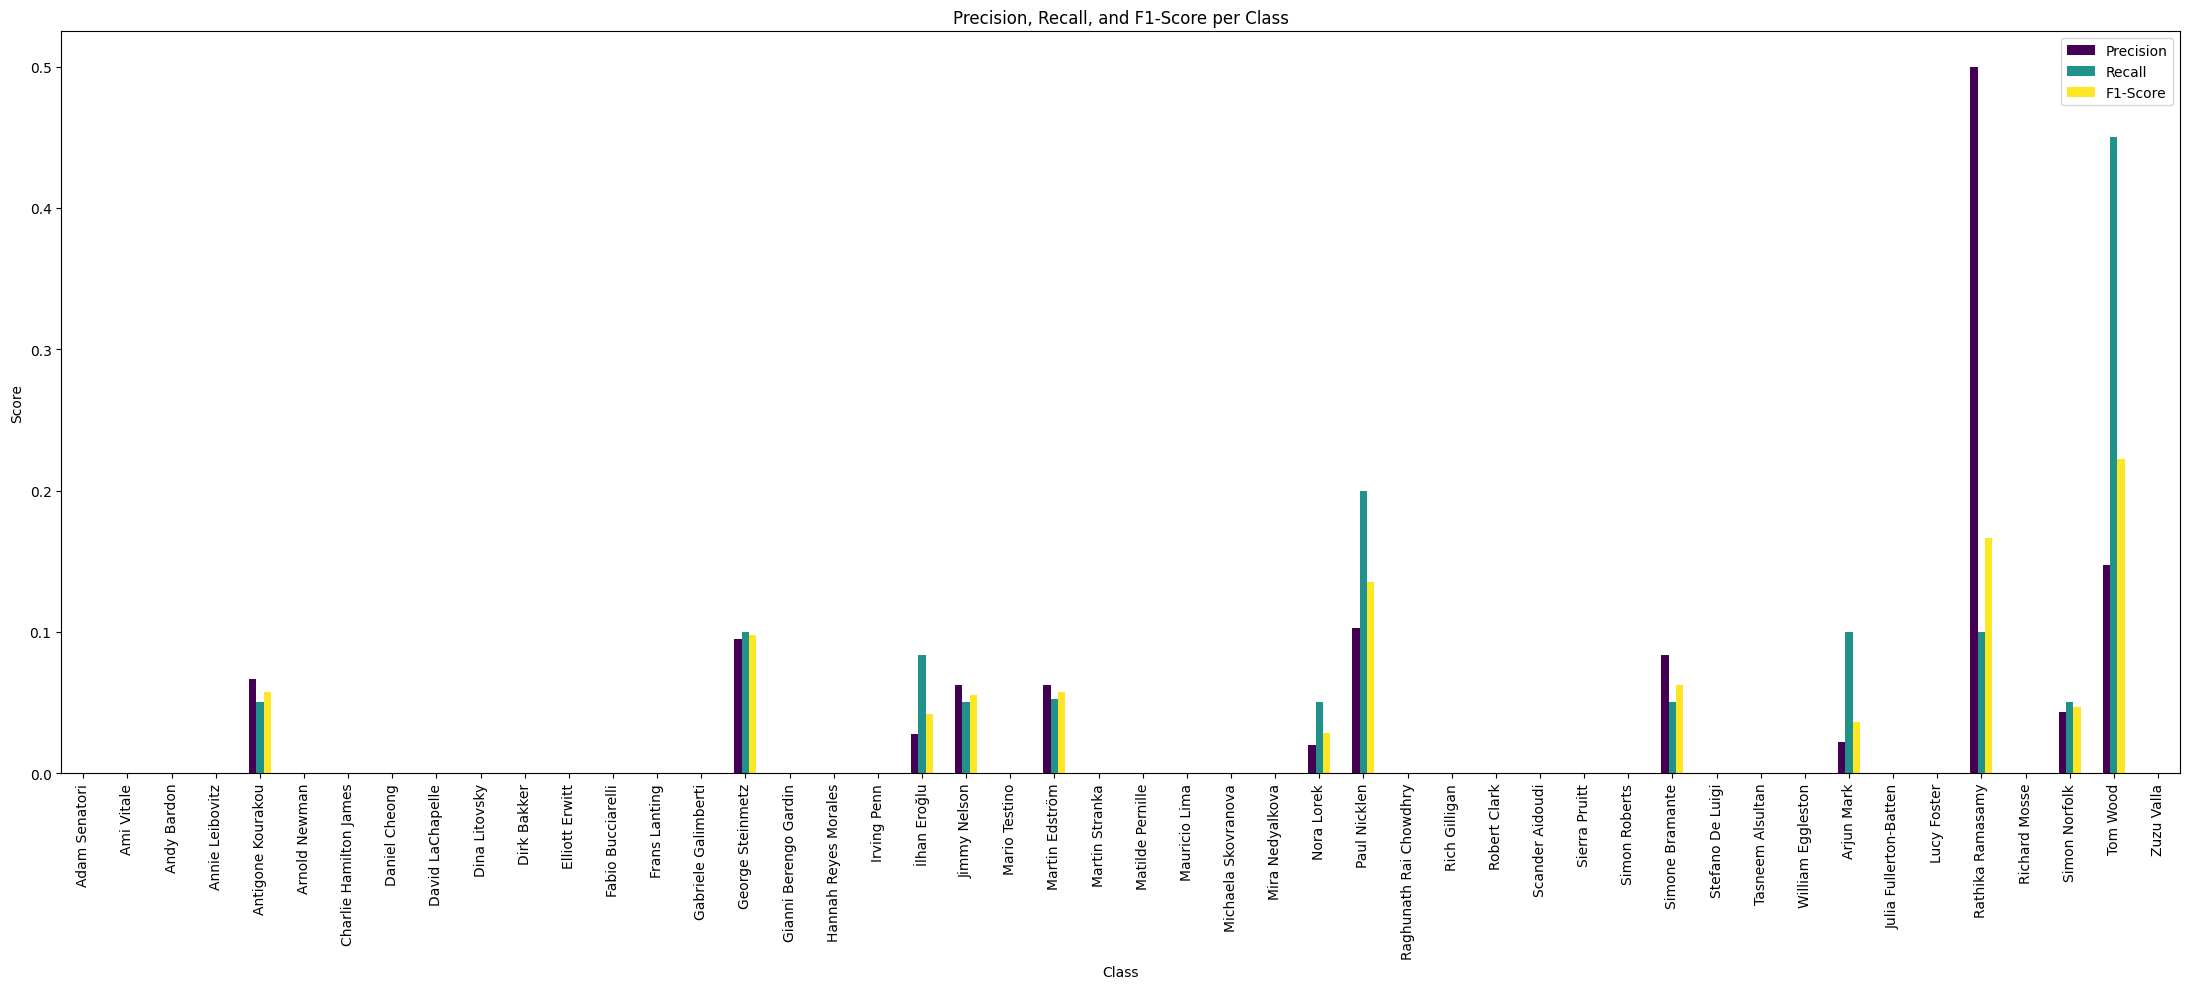

In [ ]:
plt.figure(figsize=(22, 10))
metrics = ['Precision', 'Recall', 'F1-Score']
results_plot = results[metrics]

results_plot.plot(kind='bar', figsize=(22, 10), colormap='viridis')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
